# Interpolation and reconstruction

It's not obvious how to represent a continuous-time signal $x(t)$ in a way that can be manipulated by a computer.  The time index is real-valued, so even if we only care about the signal value over a finite interval there are infinitely many function values to consider and store.  

One approach is to assume that $x(t)$ varies slowly, and hope that sampling $x(t)$ at $t=nT$ for $n$ integer and $T$ small is sufficient to characterise the signal.  This leads to the discrete-time signal $x[n] = x(nT)$.  When this assumption is formalised and holds then the method works, and we use it a lot.  The first part of this workbook explores how a discrete signal $x[n]$ can be used to represent or parameterise a continuous-time $x(t)$.  Understanding this link and its limitations lets us process "analog" signals $x(t)$ using digital processing of the corresponding $x[n]$.  See https://en.wikipedia.org/wiki/Digital_signal_processing.

A more general option is to represent the continuous-time signal $x(t)$ as a linear combination of a fixed set of known basis functions $b_n(t)$:
$$x(t) = \sum_{n=0}^{N-1} c_n b_n(t).$$
Here the signal $x(t)$ is defined for all $t \in \mathbb{R}$, but as written it is completely specified by the finite and discrete set of values $c_n, n=0, \ldots, N-1$.  Not every signal $x(t)$ can be written in this way, and those that can depends on the choice of functions $b_n(t)$.

One simple example uses a polynomial basis with $b_n(t) = t^n$.  The signals parameters $c_n$ are then just the coefficients for each polynomial order.  Another is the cosine basis $b_n(t) = \cos(n \omega_0 t)$, which can represent all periodic even functions $x(t)$ if $N$ is large enough.  Instead of summing from $0$ to $N-1$ in the representation we might also have infinite bounds like $0$ to $\infty$, or $-\infty$ to $\infty$.  Even then, the coefficients $c_n$ are still a countable set and can be carefully used to represent or process the continuous-time $x(t)$ that they represent.  The second part of this workbook explores this concept.

## Reconstruction from discrete samples

Suppose that $b_0(t)$ is an even function centered on the origin $t=0$, and for each $n$ the basis function $b_n(t)$ in the representation equation above is $b_0(t)$ shifted until it is centered on some point $t=nT$:  
$$x(t) = \sum_{n=0}^{N-1} c_n b_0(t-nT).$$
This representation is particularly useful if we add the requirement
$$b_0(t) = \begin{cases}
  1 \qquad & t=0 \\
  0 \qquad & t=nT \quad \text{for integer $n$}.
  \end{cases}
$$

Suppose now that we have access to a discrete set of regular samples $x[n] = x(nT)$ from $x(t)$, and want to determine the corresponding coefficients $c_n$.  Note that
$$x(kT) = \sum_{n=0}^{N-1} c_n b_0(kT-nT) = \sum_{n=0}^{N-1} c_n b_0((k-n)T) = c_k.$$
The last step above follows because $b_0((k-n)T)=1$ only if $k-n=0$, so all the terms in the sum are zero except one.  You could also note that $b_0((k-n)T) = \delta(k-n)$ and use the sifting property.  Either way $x[k] = x(kT) = c_k$, and the expansion takes the form
$$x(t) = \sum_{n=0}^{N-1} x[n] b_0(t-nT).$$

We can view this as a reconstruction formula.  It takes as input the sample values in the form of a discrete signal $x[n]$ for integer $n$, and produces the interpolated or reconstructed continuous-time signal $x(t)$.  The nature of the reconstruction depends on the prototype basis function $b_0(t)$, and different choices lead to interpolation with different properties.

### Basic code

We start off with an instance of a continuous-time signal and sample it according to $x[n] = x(nT)$ for some $T$.  The first subplot below shows a continuous-time signal $x(t)$, along with dots indicating a set of discrete samples of the signal.  The second subplot shows the corresponding discrete signal $x[n]$.

<IPython.core.display.Javascript object>


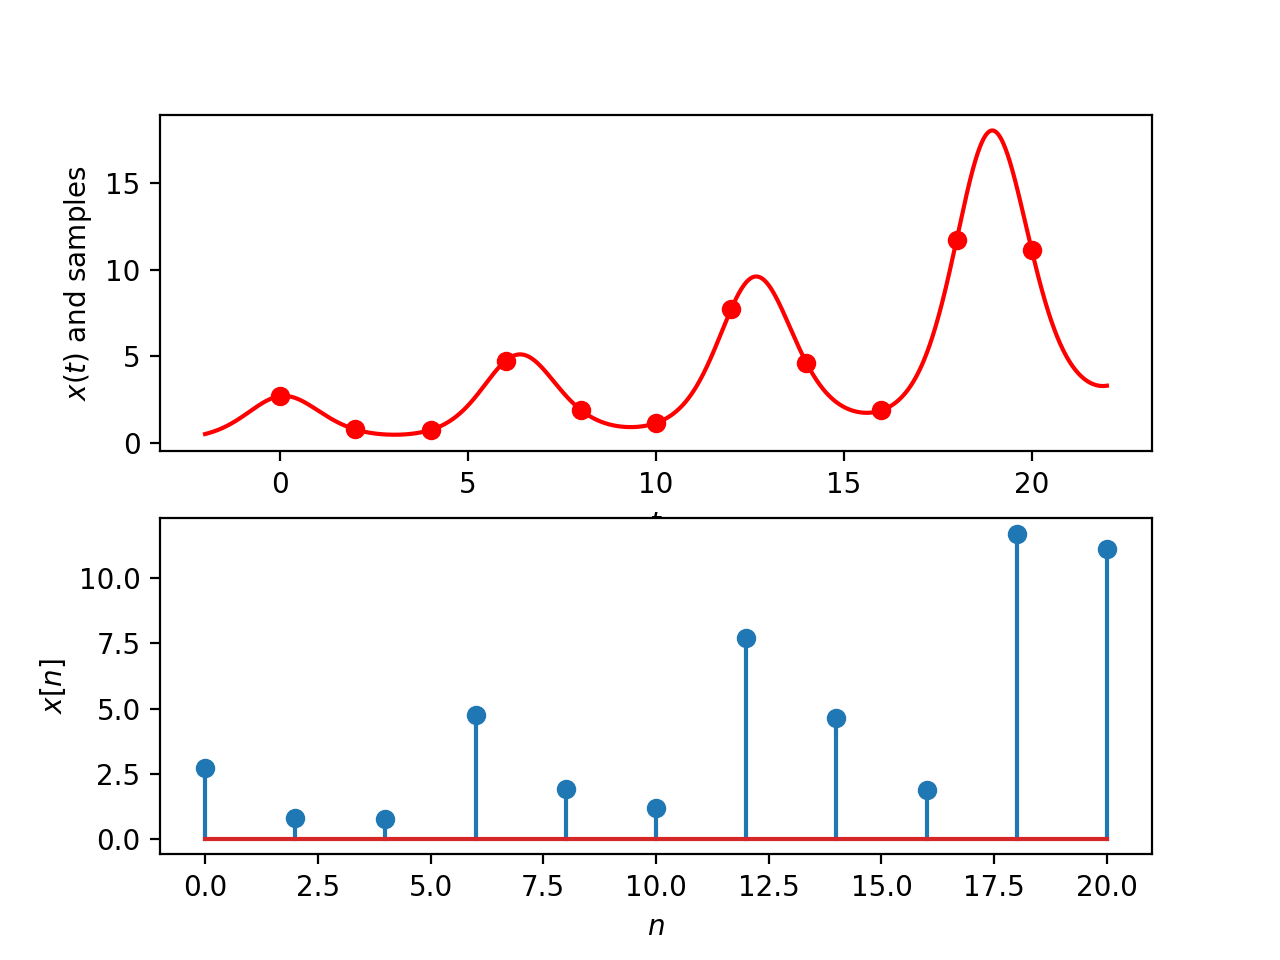

In [48]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

# Set up symbolic signal to approximate
t = sp.symbols('t');
#x = sp.cos((t-5)/5) - ((t-5)/5)**3;
x = sp.exp(sp.cos(t)+t/10)
lam_x = sp.lambdify(t, x, modules=['numpy']);

# Discrete samples of signal over required range
T = 2;  tmax = 20;
nm = np.floor(tmax/T);
tnv = T*np.arange(0,nm+1);
xnv = lam_x(tnv);

# Dense set of points for plotting "continuous" signals
tv = np.linspace(-2, tmax+2, 2500);
xv = lam_x(tv);
    
# Plots
fh, ax = plt.subplots(2);
ax[0].plot(tv,xv,'r-');  ax[0].scatter(tnv, xnv, c='r');  
ax[0].set_ylabel('$x(t)$ and samples');  ax[0].set_xlabel('$t$');
ax[1].stem(tnv, xnv);  ax[1].set_ylabel('$x[n]$');  ax[1].set_xlabel('$n$');

The code below defines and plots a triangular reconstruction or interpolation kernel $b_0(t)$ that satisfies the required conditions, namely that $b_0(nT) = \delta(n)$ for integer $n$.  Following that is the entire set of basis functions shown over the interval of interest.

<IPython.core.display.Javascript object>


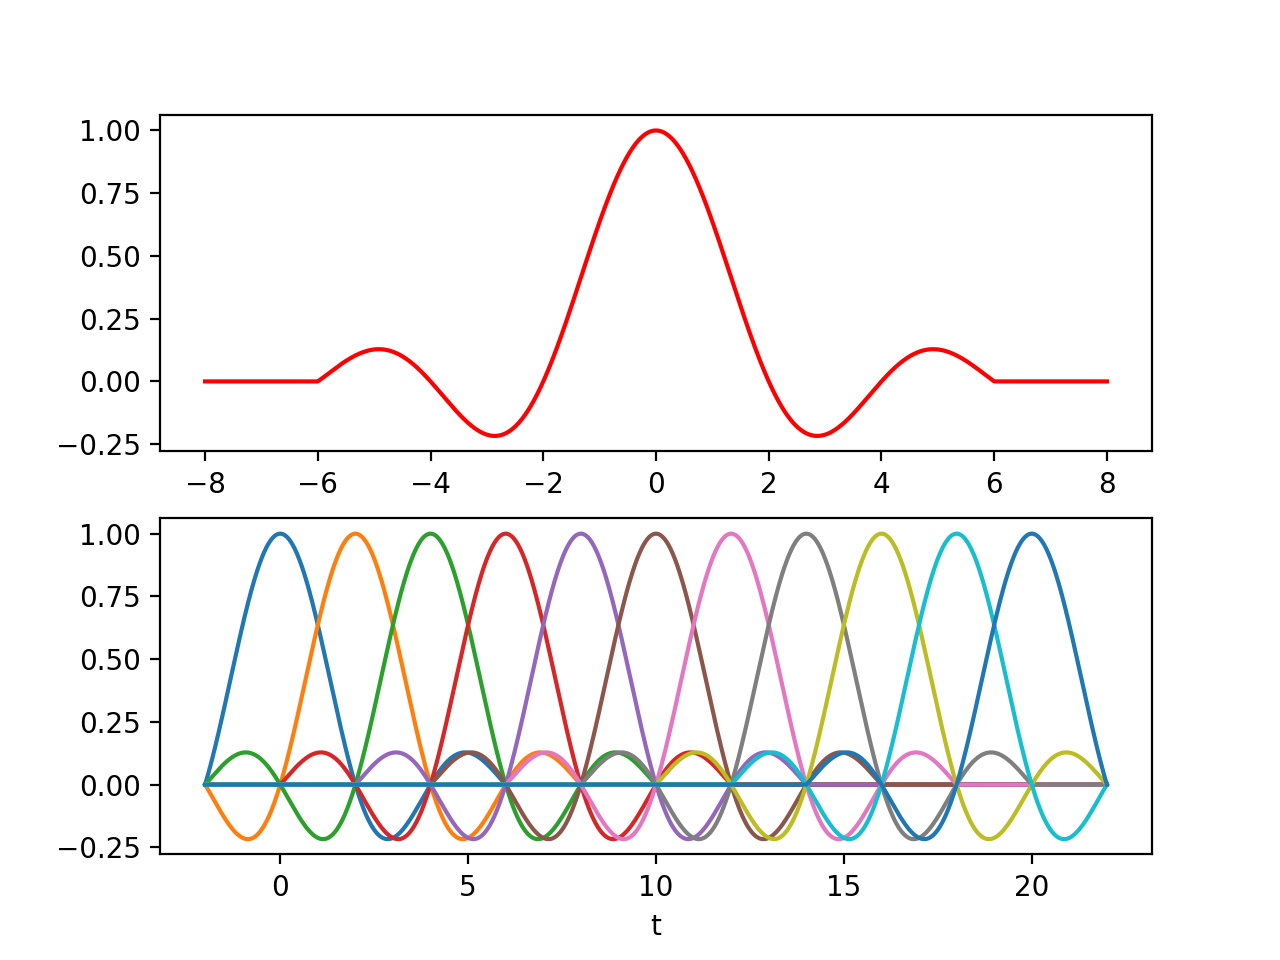

In [66]:
# Interpolation kernel
#b0 = sp.Piecewise( (0, t/T<=-1/2), (1, t/T<1/2), (0, True));  # rectangular
#b0 = sp.Piecewise( (0, t/T<=-1), (1+t/T, t<0), (1-t/T, t/T<1), (0, True));  # triangular
#at = sp.Abs(t/T);  a = -0.5;  b0 = sp.Piecewise( ((a+2)*at**3 - (a+3)*at**2 + 1 , at<1), (a*at**3 - 5*a*at**2 + 8*a*at - 4*a, at<2), (0, True));  # cubic
at = sp.Abs(t/T);  w = 3;  b0 = sp.Piecewise( (sp.sin(sp.pi*at)/(sp.pi*at), at<=w), (0, True) );  # windowed sinc
lam_b0 = sp.lambdify(t, b0.simplify(), modules=['numpy']);

# Plot kernel and reconstruction basis
tbv = np.linspace(-4*T, 4*T, 1500);
b0v = lam_b0(tbv);
fh, ax = plt.subplots(2);
ax[0].plot(tbv, b0v, 'r-');
for tn in tnv:
    ax[1].plot(tv, lam_b0(tv-tn));
ax[1].set_xlabel('t');

The first subplot below shows a continuous-time signal $x(t)$, the dots indicating a set of discrete samples of the signal, and the signal reconstructed from the dots using the reconstruction kernel above.  The second subplot shows the separate scaled components that are summed to form the reconstruction.  We observe that the reconstruction corresponds to first-order linear interpolation between the sample points, so $b_0(t)$ in this case is the linear interpolation reconstruction kernel.

<IPython.core.display.Javascript object>


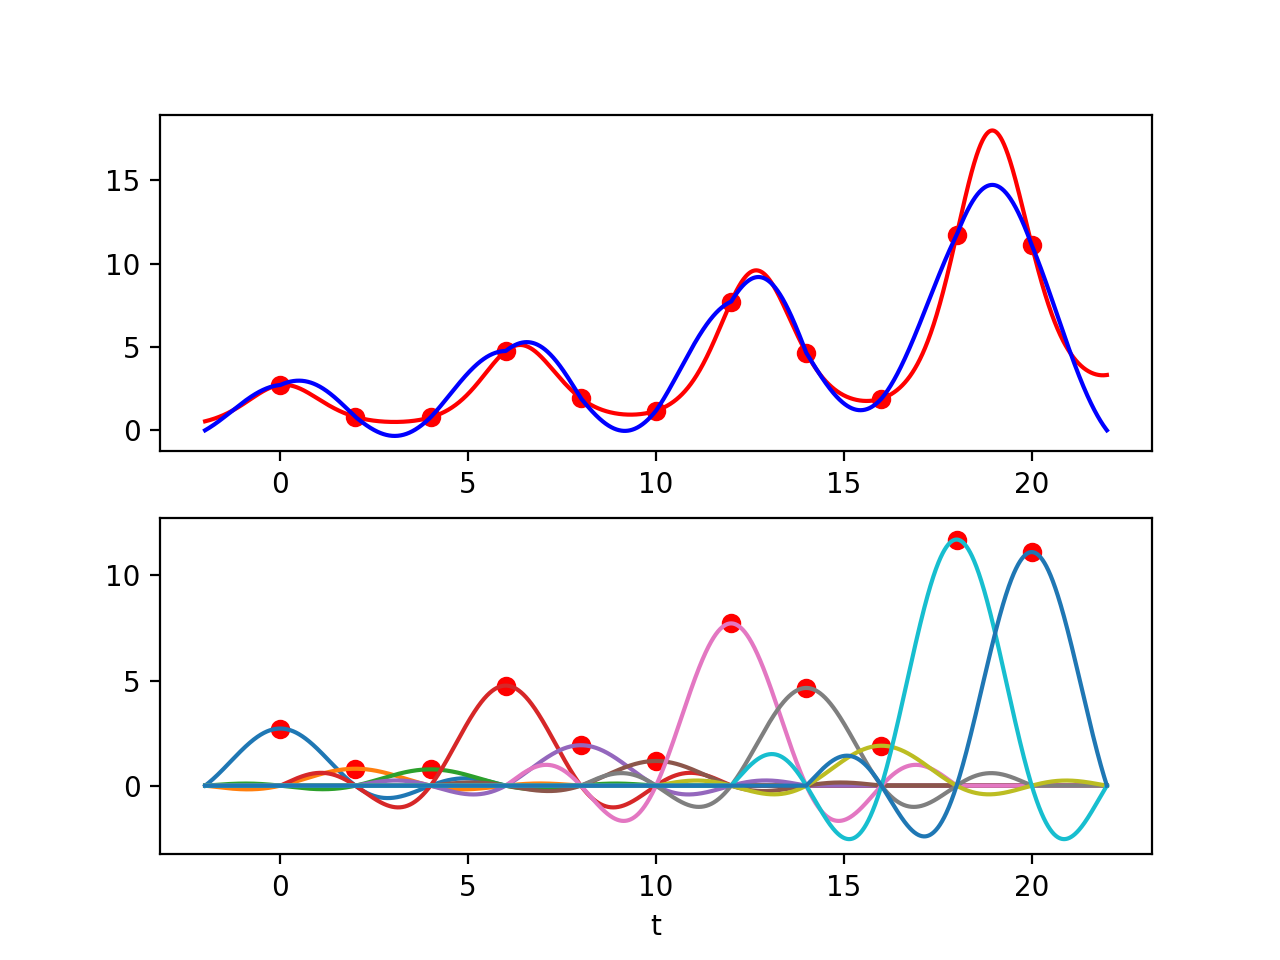

In [67]:
# Numerically evaluate linear interpolation approximation
xav = np.zeros(tv.shape);
for i in range(0,len(xnv)):   
    xav = xav + xnv[i]*lam_b0(tv - tnv[i]);
    
# Plots
fh, ax = plt.subplots(2);
ax[0].plot(tv,xv,'r-',tv,xav,'b-');
ax[0].scatter(tnv, xnv, c='r');
for i in range(0,len(xnv)):   
    ax[1].plot(tv,xnv[i]*lam_b0(tv - tnv[i]));
ax[1].scatter(tnv, xnv, c='r');  ax[1].set_xlabel('t');

The reconstruction above is quite good, but the condition that $b_0(nT) = \delta(n)$ for integer $n$ is not sufficient for it to be a good reconstruction kernel.  The code below generates a reconstruction using another basis.

<IPython.core.display.Javascript object>


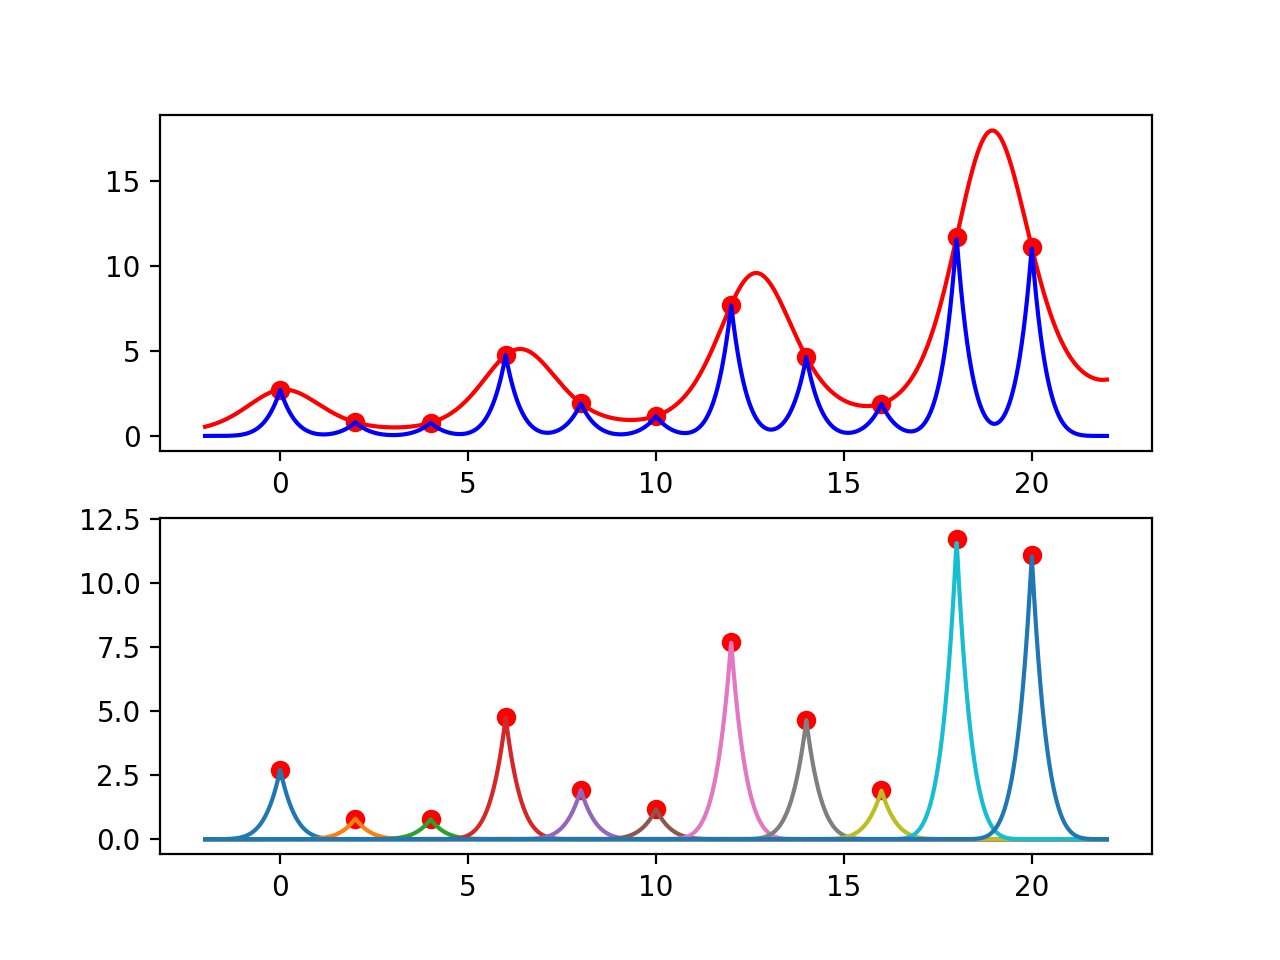

In [68]:
# Bad interpolation
b0a = sp.Piecewise( (0, t<=-T), (1+t/T, t<0), (1-t/T, t<T), (0, True))**5;
lam_b0a = sp.lambdify(t, b0a, modules=['numpy']);

# Numerically evaluate function and approximation
xava = np.zeros(tv.shape);
for i in range(0,len(xnv)):   
    xava = xava + xnv[i]*lam_b0a(tv - tnv[i]);
    
# Plot
fh, ax = plt.subplots(2);
ax[0].plot(tv,xv,'r-',tv,xava,'b-');
ax[0].scatter(tnv, xnv, c='r');
for i in range(0,len(xnv)):   
    ax[1].plot(tv,xnv[i]*lam_b0a(tv - tnv[i]));
ax[1].scatter(tnv, xnv, c='r');

This kernel again leads to perfect reconstruction of the sampled points, but the approximation is bad between them.  Evidently we also require that the interpolation kernel $b_0(t)$ also be smooth in some sense.  The ideal bandlimited interpolation kernel with no high-frequency components is the *sinc* function
$$b_0(t) = \frac{\sin(\pi t/T)}{\pi t/T},$$
which leads to the reconstruction below.  In this case if the signal $x(t)$ were actually bandlimited then the reconstruction would be exact.

<IPython.core.display.Javascript object>


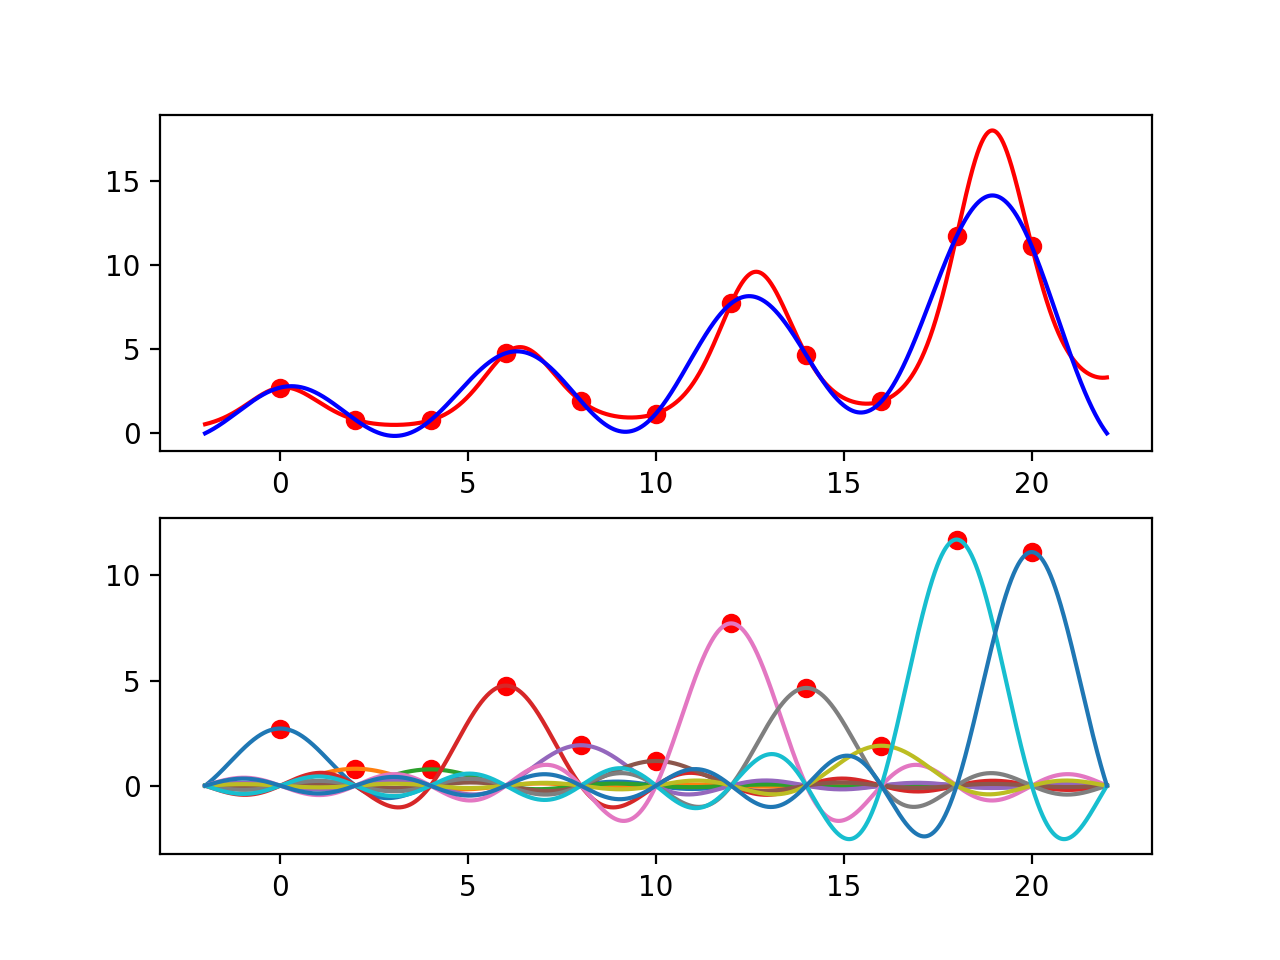

In [69]:
# Sinc interpolation
b0b = sp.sin(sp.pi*t/T)/(sp.pi*t/T);
lam_b0b = sp.lambdify(t, b0b, modules=['numpy']);

# Numerically evaluate function and approximation
xavb = np.zeros(tv.shape);
for i in range(0,len(xnv)):   
    xavb = xavb + xnv[i]*lam_b0b(tv - tnv[i]);
    
# Plot
fh, ax = plt.subplots(2);
ax[0].plot(tv,xv,'r-',tv,xavb,'b-');
ax[0].scatter(tnv, xnv, c='r');
for i in range(0,len(xnv)):   
    ax[1].plot(tv,xnv[i]*lam_b0b(tv - tnv[i]));
ax[1].scatter(tnv, xnv, c='r');

One usually has some difficulty making the approximation accurate near the boundary of the observation interval.  Dealing with the boundary of a signal that is only observed for a finite time is a difficult part of signal processing:  the models usually assume time invariance, which means that functions are observed and go on forever.

### Interpretation

The representation formula used above suggests that we can reconstruct $x(t)$ using the expression
$$x(t)= \sum_{n=-\infty}^{\infty} x[n] b_0(t-nT).$$
Here we've increased the range of the summation to include all $n$.  This can also be written as the convolution
$$x_r(t) = x_s(t) \ast b_0(t)$$
where $x_s(t)$ is the modulated impulse train
$$x_s(t) = \sum_{n=-\infty}^{\infty} x[n] \delta(t-nT).$$

The interpretation is this:  given a discrete signal $x[n]$ obtained from regular samples of $x(t)$, we can generate a reconstruction $x_r(t)$ by forming a modulated impulse train $x_s(t)$ and filtering it with the reconstruction filter $b_0(t)$.  

![](figures/sampxtime.png)

If $x(t)$ is bandlimited with a sufficiently small sample spacing, and $b_0(t)$ is the ideal sinc interpolation kernel, then we will have $x_r(t) = x(t)$ and the representation or reconstruction is perfect.

## Radial basis function approximation

Another interesting example that is investigated in this section is the use of *radial basis functions* (RBFs).  

Suppose that $b_0(t)$ is again an even function centered on the origin $t=0$, and for each $n$ the basis function $b_n(t)$ is just $b_0(t)$ shifted until it is centered on some point $t=t_n$.  Then 
$$x(t) = \sum_{n=0}^{N-1} c_n \, b_0(t - t_n).$$
The function $b_0(t)$ and the centers $t_0, \ldots, t_{N-1}$ are specified in advance, and the coefficients $c_n$ are chosen so that the approximation matches the actual $x(t)$.

For demonstration we use the prototype basis $b_0(t) = e^{-t^2/\sigma^2}$ with $\sigma=1$.  Earlier in this workbook we assumed $t_n=nT$, and while we do so again this is not in general required for an RBF network.  We also do not assume that $b_0(nT) = \delta(n)$, and this makes it more difficult to specify the coefficients.  The prototype basis $b_0(t)$ and example basis functions $b_n(t) = b_0(t - t_n)$ in the representation are evaluated and plotted by the code below.

<IPython.core.display.Javascript object>


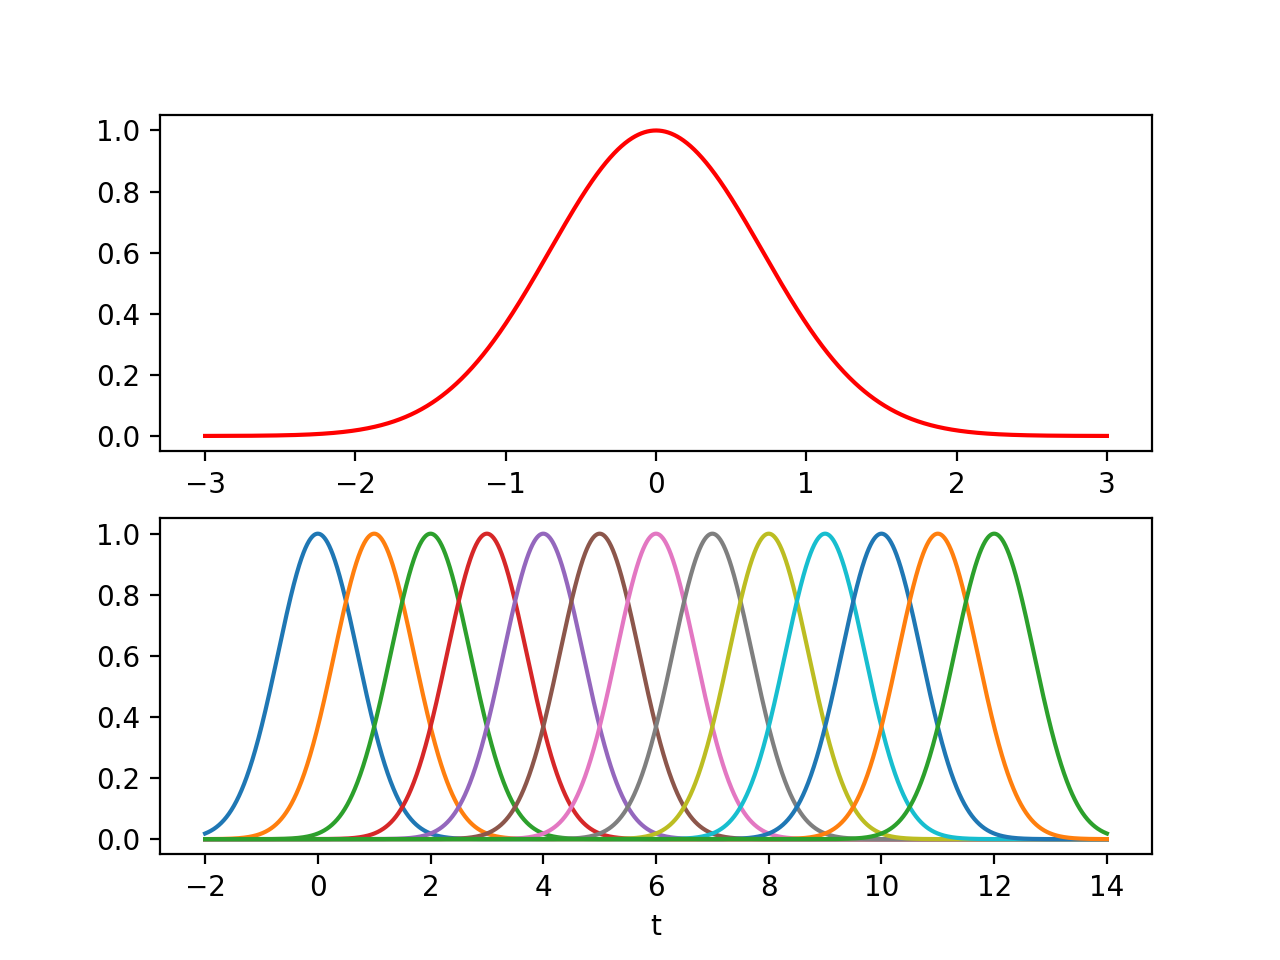

In [260]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

# Prototype basis function
sigma = 1;
t = sp.symbols('t');
b0r = sp.exp(-t**2/sigma**2);
lam_b0r = sp.lambdify(t, b0r, modules=['numpy']);

# Discretisation details and basis centers
tmax = 12;
Tc = 1;  nmc = int(np.floor(tmax/Tc));
tnv = Tc*np.arange(0,nmc+1);
#tnv = np.random.uniform(0, tmax, nm+1);  # random basis centers

# Plot prototype and reconstruction basis
tv = np.linspace(-2, tmax+2, 2500);
tbv = np.linspace(-3*sigma, 3*sigma, 1500);  b0v = lam_b0r(tbv);
fh, ax = plt.subplots(2);
ax[0].plot(tbv, b0v, 'r-');
for tn in tnv:
    ax[1].plot(tv, lam_b0r(tv-tn));
ax[1].set_xlabel('t');

Finding the required values for $c_n$ given a function $x(t)$ to be approximated depends on the particular problem.  In this case we again simply require that the function $x(t)$ and the approximation agree on their values at $t=kT$ for some set of integers $k$.  As long as this set has more than $N$ elements then we have more than $N$ equations in $N$ unknowns, which can be solved if the resulting system is not underdetermined.  

The code below calculates the coefficients for the function
$$x(t) = \cos\left( \frac{t-5}{5} \right) - \left( \frac{t-5}{5} \right)^3$$
by formulating a matrix equation and solving.  Each value of $k$ leads to a single sample point and an equation of the form
$$x(kT) = \sum_{n=0}^{N-1} c_n b_0(kT - t_n)
= \begin{pmatrix} b_0(kT-t_0) & \cdots & b_0(kT-t_{N-1}) \end{pmatrix}
\begin{pmatrix} c_0 \\ \vdots \\ c_{N-1} \end{pmatrix}.$$
If we consider $k=0, \ldots, M-1$ this leads to the system of equations
$$\begin{pmatrix} x(0T) \\ \vdots \\ x((M-1)T) \end{pmatrix}
= \begin{pmatrix} 
b_0(0T-t_0) & \cdots & b_0(0T-t_{N-1}) \\
\vdots & \ddots & \vdots \\
b_0((M-1)T-t_0) & \cdots & b_0((M-1)T-t_{N-1})
\end{pmatrix}
\begin{pmatrix} c_0 \\ \vdots \\ c_{N-1} \end{pmatrix},$$
which is of the form $\mathbf{b} = \mathbf{B} \mathbf{c}$.  In general if this system is overdetermined (which is usually true if $M>N$) then the least squares solution is often appropriate:
$$\mathbf{c} = (\mathbf{B}^T \mathbf{B})^{-1} \mathbf{B}^T \mathbf{b}.$$
See https://en.wikipedia.org/wiki/Least_squares for details if interested.

In [266]:
from numpy.linalg import pinv

# Set up signal to approximate
x = sp.cos((t-5)/5) - ((t-5)/5)**3;
#x = sp.sin(t+0.5) + 5*(1 - sp.exp(-(t+0.5)));  # reconstruction points
lam_x = sp.lambdify(t, x, modules=['numpy']);

# Evaluate basis matrix and value for periodic observations
M = int(1.0*len(tnv));  # M = 2*len(tnv);
T = tmax/(M-1);
B = np.zeros((M,len(tnv)));  b = np.zeros(M);
for k in range(0,M):
    b[k] = lam_x(k*T);
    for n in range(0,len(tnv)):
        B[k,n] = lam_b0r(k*T - tnv[n]);
        
# Solve for coefficients
cv = pinv(B).dot(b);
print(cv);

[ 1.35834594  0.46235455  0.64432842  0.5208424   0.56564884  0.56715441
  0.55934324  0.50895771  0.34921072  0.18851101 -0.36759327 -0.33474544
 -2.44417749]


The coefficient vector `cv` now specifies the particular instance of the approximation function.  The code below plots both the approximation and the actual function for a dense set of time points, and then shows the scaled basis contributions.

<IPython.core.display.Javascript object>


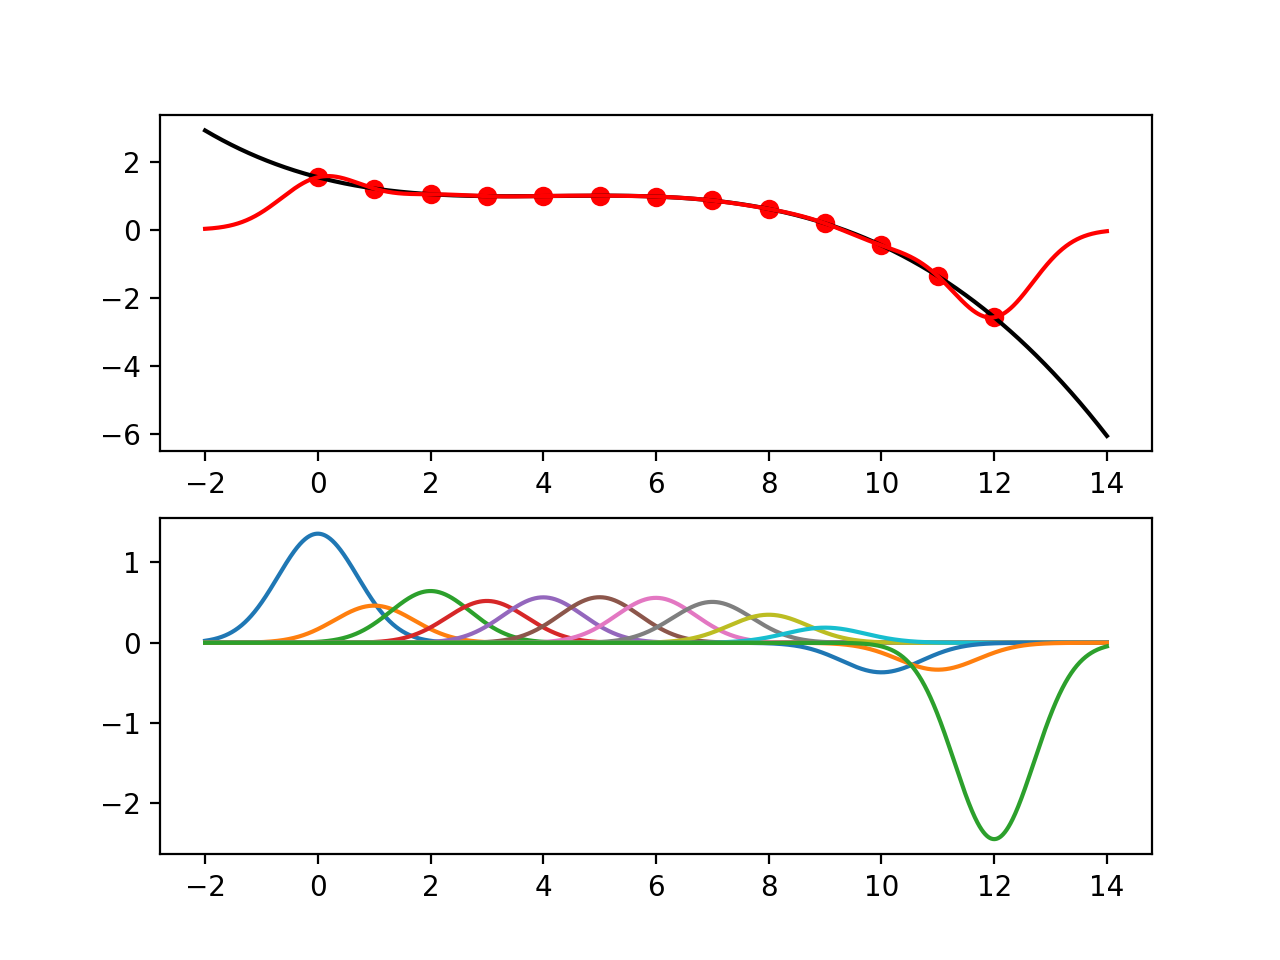

In [267]:
# Numerically evaluate approximation
xav = np.zeros(tv.shape);
for n in range(0,len(tnv)):   
    xav = xav + cv[n]*lam_b0r(tv - tnv[n]);
    
# Plot
fh, ax = plt.subplots(2);
ax[0].plot(tv,lam_x(tv),'k-',tv,xav,'r-');
ax[0].scatter(np.arange(0,M)*T, b, c='r');
for n in range(0,len(tnv)):   
    ax[1].plot(tv,cv[n]*lam_b0r(tv - tnv[n]));

For the case where $M=N$ the series approximation will match the actual function values at all the points used to estimate the coefficients.  However, we have no control of the quality of the approximation between these points.  Also observe that if we increase $\sigma$ then the approximation becomes smoother, and vice versa.  Without knowing the degree of smoothness of $x(t)$ it is however difficult to know what value is appropriate, and in general we might not even have an expression for it that we can plot.

The radial basis function approach shown here is a local representation:  each basis function only influences on a small neighbourhood of points around its center.  This is convenient but isn't required.  A polynomial basis, for example, does not have this property, and neither does a sinusoidal basis.  

Finding the coefficients for a general basis, even for the sampling-based method presented above which is not without flaws, is computationally complex:  for a $N$ element basis we have to invert a $N \times N$ matrix.  With a different basis we can improve on this situation.  For example, the requirement that $b_0(nT) = \delta(n)$ used earlier in this workbook imposes an *orthogonality* condition on the problem that makes it easier to find the coefficients.

# Tasks

These tasks involve writing code, or modifying existing code, to meet the objectives described.

1.  Suppose we have samples $x[n] = x(nT)$ of the signal
$$x(t) = \cos\left( \frac{t-5}{5} \right) - \left( \frac{t-5}{5} \right)^3$$
for $n=0, \ldots, N-1$, with $N=10$ and $T = 1.2$.  Consider the reconstruction equation
$$x_r(t) = \sum_{n=0}^{N-1} x[n] b_0(t-nT).$$
On the same set of axes plot both $x(t)$ and $x_r(t)$ over the range $t = 0$ to $t=(N-1)T$ for the case of a box filter interpolant $b_0(t) = p_T(t) = p_1(t/T)$, where $p_T(t)$ is the unit pulse of total width $T$ centered on the origin.<br><br>

2.  Generate two new plots with the same specifications as for the previous task, but using these interpolation kernels:

    A.  Cubic kernel $b_0(tT) = 
    \begin{cases}
      (a+2)|t|^3 - (a+3)|t|^2 + 1 \qquad & 0 \leq |t| < 1 \\
      a|t|^3 - 5a|t|^2 + 8a|t| - 4a \qquad & 1 \leq |t| < 2 \\
      0 \qquad & 2 \leq |t|
    \end{cases}
    $ <br>
    with $a=-1/2$.

    B.  Truncated or windowed sinc function $b_0(tT) = \frac{\sin(\pi t)}{\pi t} p_{2w}(t)$ for $w=3$.<br><br>
    
3.  Use a representation of the form
$$x_r(t) = \sum_{n=0}^{N-1} c_n b_n(t)$$
with a polynomial basis $b_n(t) = t^n$ to approximate the signal $x(t) = e^{(t/10 + cos(t))}$.  The coefficients should be calculated using least squares from the samples $x[n] = x(nT)$ for $T=1$ and $n=0, \ldots, M-1$.  On a single set of axes show the signal $x(t)$, the reconstruction $x_r(t)$, and the sampled points, for the case of $N=9$ and $M=11$.  The domain of the plot should be from $t=0$ to $t=10$.<br><br>

4.  (optional) Repeat the previous task using a cosine basis $b_n(t) = \cos(\omega_0 n t)$ with $\omega_0 = 2\pi/10$ and $N = 6$.